In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Extract MNIST data</h2>
<p style="font-size:20px">You can change the option of one_hot encoding.

In [14]:
#get mnist data, with one_hot encoding
mnist = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(train_images, train_labels), (test_images, test_labels) = mnist
tl = train_labels
train_images = train_images.astype("float32")/255.0
test_images = test_images.astype("float32")/255.0
train_labels = tf.one_hot(train_labels,depth=10)
test_labels = tf.one_hot(test_labels, depth=10)

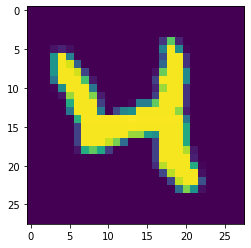

In [3]:
plt.figure()
plt.imshow(train_images[20])
plt.grid(False)
plt.show()

<h2>Define hyperparameters</h2>

In [4]:
NUM_ITER = 100
lr = 0.01
batch_size = 64
num_input = 784
n_hidden_1 = 100
n_hidden_2 = 100
num_classes = 10

<h2>Define placeholder and Variables</h2>

In [5]:
def mnist_model(hp):
    """
    define hp tune
    """
    activation = hp.Choice("activation", values=['relu', 'tanh', 'sigmoid', "softmax"])

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=16, max_value=256, step=16),
                activation=activation,
            )
        )
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1.0, 1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    return model

<h2>Define tuner</h2>

In [6]:
tuner = kt.Hyperband(
    mnist_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='keras_tuner'
)



stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project my_dir\keras_tuner\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\keras_tuner\tuner0.json
Search space summary
Default search space size: 9
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'softmax'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 1.0, 'conditions': [], 'values': [1.0, 0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, '

In [7]:
#START TUNING
tuner.search(train_images, train_labels, epochs=3, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Search: Running Trial #26

Hyperparameter    |Value             |Best Value So Far 
activation        |relu              |relu              
num_layers        |5                 |3                 
units_0           |128               |128               
units_1           |176               |32                
learning_rate     |0.001             |0.001             
units_2           |256               |240               
units_3           |224               |96                
units_4           |240               |32                
units_5           |48                |None              
tuner/epochs      |10                |10                
tuner/initial_e...|4                 |4                 
tuner/bracket     |1                 |2                 
tuner/round       |1                 |2                 
tuner/trial_id    |6cc529a8de49e28...|da3db7fd4def699...

Epoch 5/10
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0483 - accuracy: 0.9137 - val_loss: 0.

KeyboardInterrupt: 

<h2>Define cost function and accuracy</h2>

<h2>Execute training</h2>

In [13]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, batch_size=64, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0621 - accuracy: 0.8967 - val_loss: 0.0261 - val_accuracy: 0.9547
Epoch 2/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0222 - accuracy: 0.9649 - val_loss: 0.0205 - val_accuracy: 0.9652
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0158 - accuracy: 0.9748 - val_loss: 0.0159 - val_accuracy: 0.9733
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0124 - accuracy: 0.9810 - val_loss: 0.0158 - val_accuracy: 0.9745
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0099 - accuracy: 0.9846 - val_loss: 0.0153 - val_accuracy: 0.9755
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0082 - accuracy: 0.9866 - val_loss: 0.0145 - val_accuracy: 0.9754
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0069 - accuracy: 0.9894 - val_loss: 0.0148 - val_accuracy: 0.9778
Epoch 

<h2>Your results</h2>

In [20]:
acc=model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0202 - accuracy: 0.9791
